![Partners](../images/partners.png)

# Renewable Energy Plants

In this notebook we will use the Renewable Power Plants databae (RePP) Africa that was implemented by the University of Tubingen in 2023 [1]. This is a spatial database for existing and proposed power plans (solar, wind and hydro) in Africa. The database contains information on the location, capacity, country and construction status. 

* Link to viewer: https://www.repp.geo.uni-tuebingen.de/
* Link to paper: https://www.nature.com/articles/s41597-022-01922-1

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
import folium
from folium import plugins

In [20]:
gdf = gpd.read_file("data/RePP/RePP_short_FeaturesToJSON.geojson")
gdf.head()

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
0,1,Hydro power,10018,4.072917,10.692717,Cameroon,Grand Eweng,P,P,1800.0,very large,Reservoir,2027.0,20.09.2022; 11:42,POINT (10.69272 4.07292)
1,2,Hydro power,10033,5.081279,10.827113,Cameroon,Noun-Wouri,P,P,1200.0,very large,Reservoir,NaN,13.10.2022; 13:59,POINT (10.82711 5.08128)
2,3,Hydro power,10052,-4.785417,14.856250,"Congo, Rep.",Kiniangui,P,P,1968.0,very large,,NaN,20.10.2022; 22:47,POINT (14.85625 -4.78542)
3,4,Hydro power,10103,-5.541800,13.541800,DR Congo,Inga IV,P,P,7180.0,very large,Reservoir,2030.0,21.09.2022; 08:28,POINT (13.5418 -5.5418)
4,5,Hydro power,10104,-5.541800,13.541800,DR Congo,Inga V,P,P,6970.0,very large,Reservoir,2030.0,20.10.2022; 13:49,POINT (13.5418 -5.5418)


In [33]:
icpac_countries = [
    "Burundi",
    "Djibouti",
    "Eritrea",
    "Ethiopia",
    "Kenya",
    "Rwanda",
    "Somalia",
    "South Sudan",
    "Sudan",
    "Tanzania",
    "Uganda"
]

gdf_icpac = gdf[gdf["country"].isin([c for c in icpac_countries])]
gdf_icpac.head()

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
10,11,Hydro power,10208,11.214583,35.093056,Ethiopia,Grand Ethiopian Renaissance Dam (Gerd),U,U,4875.0,very large,Reservoir,NaN,21.09.2022; 09:10,POINT (35.09306 11.21458)
11,12,Hydro power,10209,6.627805,36.602805,Ethiopia,Koysha (Gilgel Gibe IV),U,U,2200.0,very large,Reservoir,2025.0,15.10.2022; 16:41,POINT (36.6028 6.6278)
12,13,Hydro power,10211,10.072917,35.544080,Ethiopia,Mendya,P,P,1700.0,very large,Reservoir,NaN,15.10.2022; 16:41,POINT (35.54408 10.07292)
13,14,Hydro power,10212,9.004487,36.152083,Ethiopia,Bekoabo,P,P,2000.0,very large,Reservoir,2028.0,21.09.2022; 09:10,POINT (36.15208 9.00449)
14,15,Hydro power,10217,6.847627,37.302083,Ethiopia,Gilgel Gibe III,O,E,1870.0,very large,Reservoir,2014.0,21.09.2022; 09:10,POINT (37.30208 6.84763)


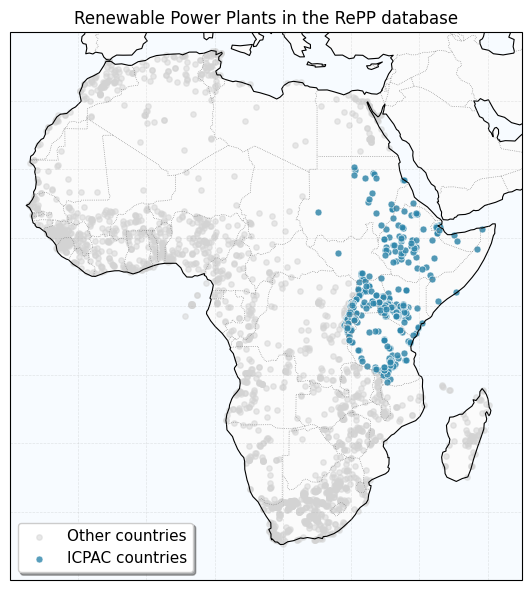

In [22]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='gray')
ax.add_feature(cartopy.feature.LAND, facecolor='#f5f5f5', alpha=0.3)
ax.add_feature(cartopy.feature.OCEAN, facecolor='#e6f2ff', alpha=0.3)
gdf.plot(ax=ax, alpha=0.5, color="#d3d3d3", markersize=15, label="Other countries")
gdf_icpac.plot(ax=ax, alpha=0.8, color="#2E86AB", markersize=25, edgecolor='white', linewidth=0.5, label="ICPAC countries")
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
ax.set_title("Renewable Power Plants in the RePP database")
ax.legend(loc='lower left', frameon=True, fancybox=True, shadow=True, fontsize=11)
ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.3, linestyle='--')
plt.tight_layout()


## Capacity Analysis by Country and Energy Type

Let's analyze the installed capacity across ICPAC countries for different renewable energy sources.

In [5]:
# Filter for operating plants only
gdf_operating = gdf_icpac[gdf_icpac.stat_ele == "O"]

# Group by country and energy source to get total capacity
capacity_by_country = gdf_operating.groupby(['country', 'RE_source'])['g_cap_mw'].sum().reset_index()

The database includes two key status columns:

- **`stat_ele`** (Electricity Generation Status): Indicates whether a power plant is currently producing electricity
  - **O** = Operating (actively generating electricity)
  - **NO** = Not Operating (facility exists but temporarily not producing electricity)
  - **U** = Under Construction
  - **P** = Proposed

- **`stat_inf`** (Infrastructure Status): Indicates the physical existence state of the power plant
  - **E** = Existing (facility is built and present)
  - **U** = Under Construction (facility is being built)
  - **P** = Proposed (planned but not yet built)

**Example:** A plant can have `stat_inf = "E"` (the infrastructure exists) but `stat_ele = "NO"` (temporarily not operating due to maintenance, damage, or other reasons).

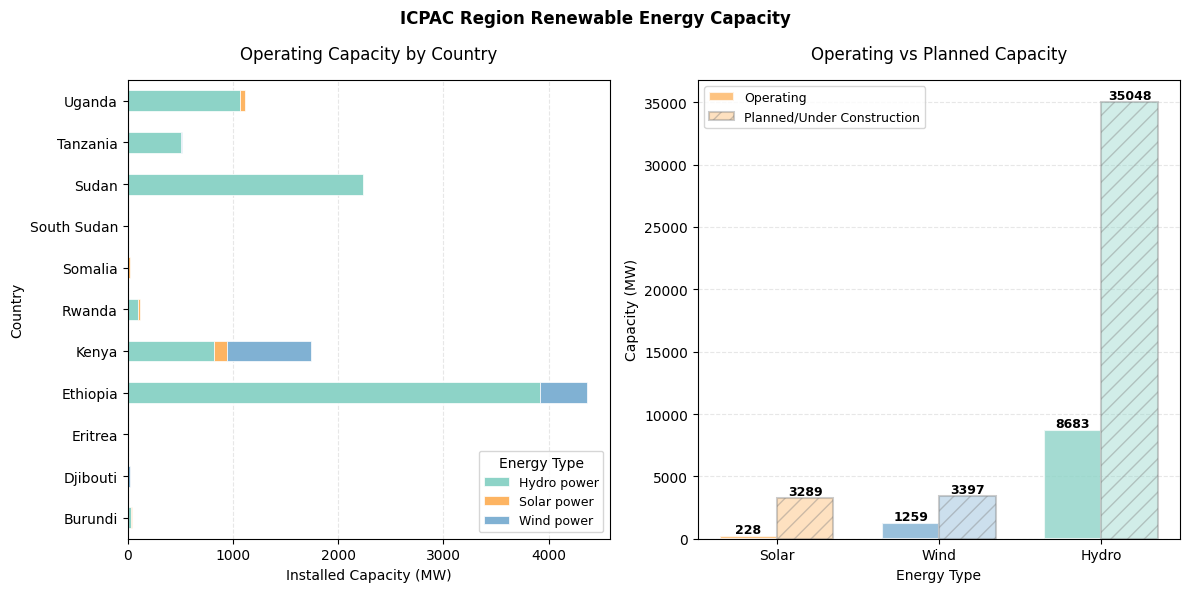

In [27]:

# Prepare data for operating and planned plants
gdf_planned = gdf_icpac[gdf_icpac.stat_ele.isin(["U", "P"])]  # Under construction or Proposed

capacity_planned = gdf_planned.groupby(['country', 'RE_source'])['g_cap_mw'].sum().reset_index()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Color scheme for energy types
colors = {'Solar power': '#FDB462', 'Wind power': '#80B1D3', 'Hydro power': '#8DD3C7'}

# 1. Operating Capacity by Country - Stacked Bar Chart
pivot_data = capacity_by_country.pivot(index='country', columns='RE_source', values='g_cap_mw').fillna(0)
pivot_data.plot(kind='barh', stacked=True, ax=ax1, 
                color=[colors.get(x, '#999999') for x in pivot_data.columns],
                edgecolor='white', linewidth=0.5)
ax1.set_xlabel('Installed Capacity (MW)')
ax1.set_ylabel('Country')
ax1.set_title('Operating Capacity by Country', pad=15)
ax1.legend(title='Energy Type', loc='lower right', frameon=True, fontsize=9)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# 2. Operating vs Planned Comparison

# Aggregate data by energy type
operating_totals = capacity_by_country.groupby('RE_source')['g_cap_mw'].sum()
planned_totals = capacity_planned.groupby('RE_source')['g_cap_mw'].sum()

# Ensure all energy types are represented
all_types = list(colors.keys())
operating_vals = [operating_totals.get(t, 0) for t in all_types]
planned_vals = [planned_totals.get(t, 0) for t in all_types]

x_pos = np.arange(len(all_types))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, operating_vals, width, label='Operating',
                color=[colors[t] for t in all_types], alpha=0.8, edgecolor='white', linewidth=1.5)
bars2 = ax2.bar(x_pos + width/2, planned_vals, width, label='Planned/Under Construction',
                color=[colors[t] for t in all_types], alpha=0.4, edgecolor='gray', linewidth=1.5, hatch='//')

ax2.set_ylabel('Capacity (MW)')
ax2.set_xlabel('Energy Type')
ax2.set_title('Operating vs Planned Capacity', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([t.replace(' power', '') for t in all_types], fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('ICPAC Region Renewable Energy Capacity', fontweight='bold')
plt.tight_layout()
plt.show()

## Explore specific country data

In [28]:
# Select country to visualize
selected_country = "Kenya"  # Change this to any country from: Burundi, Djibouti, Eritrea, Ethiopia, Rwanda, Somalia, South Sudan, Sudan, Tanzania, Uganda

# Filter data for selected country
country_data = gdf_icpac[gdf_icpac.country == selected_country]

if len(country_data) > 0:
    # Calculate center of the country using coordinates directly
    center_lat = country_data.geometry.y.mean()
    center_lon = country_data.geometry.x.mean()
    
    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='OpenStreetMap')
    
    # Color scheme matching the bar charts
    color_map = {
        'Solar power': '#FDB462',
        'Wind power': '#80B1D3',
        'Hydro power': '#8DD3C7'
    }
    
    # Add markers for each plant
    for idx, row in country_data.iterrows():
        # Get plant info
        plant_name = row.get('HPP_name', 'Unknown')
        energy_type = row['RE_source']
        capacity = row.get('g_cap_mw', 0)
        status = row.get('stat_ele', 'Unknown')
        
        # Create popup text
        popup_text = f"""
        <b>{plant_name}</b><br>
        Type: {energy_type}<br>
        Capacity: {capacity:.1f} MW<br>
        Status: {status}
        """
        
        # Add marker
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            popup=folium.Popup(popup_text, max_width=200),
            color='white',
            weight=1,
            fill=True,
            fillColor=color_map.get(energy_type, '#999999'),
            fillOpacity=0.7
        ).add_to(m)
    
    # Add title
    title_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 300px; height: 50px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:16px; font-weight: bold; padding: 10px">
    Renewable Energy Plants - {selected_country}
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    display(m)
else:
    print(f"No data available for {selected_country}")

In [32]:
# list of all operating solar power plants in the selected country   
country_data[(country_data['RE_source'] == 'Solar power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
1323,1324,Solar power,394,-0.315675,39.699337,Kenya,Garissa,O,E,54.700,medium,PV,2018.0,06.10.2022; 11:05,POINT (39.69934 -0.31568)
1321,1322,Solar power,374,0.414411,35.357536,Kenya,Eldosol,O,E,40.000,medium,PV,2021.0,06.10.2022; 10:58,POINT (35.35754 0.41441)
1342,1343,Solar power,436,-0.937870,38.061010,Kenya,Mwingi,O,E,12.000,medium,PV,2013.0,08.11.2022; 17:37,POINT (38.06101 -0.93787)
1909,1910,Solar power,378,-1.211094,36.795039,Kenya,Two Rivers,O,E,2.000,small,PV,2016.0,06.10.2022; 12:26,POINT (36.79504 -1.21109)
1910,1911,Solar power,380,-1.251138,36.866140,Kenya,Kenya School of Monetary Studies,O,E,2.000,small,PV,2018.0,06.10.2022; 11:24,POINT (36.86614 -1.25114)
1907,1908,Solar power,376,-1.365940,36.911180,Kenya,Kapa Oil Refineries,O,E,1.500,small,PV,2019.0,08.11.2022; 16:52,POINT (36.91118 -1.36594)
1917,1918,Solar power,388,0.149402,34.934226,Kenya,Kaimosi Tea Estates,O,E,1.500,small,PV,2020.0,06.10.2022; 11:18,POINT (34.93423 0.1494)
1911,1912,Solar power,381,-1.222337,36.897215,Kenya,International Centre of Insects Physiology and...,O,E,1.154,small,PV,2018.0,06.10.2022; 11:14,POINT (36.89721 -1.22234)
1918,1919,Solar power,389,-0.247880,35.730070,Kenya,Fontana Farms - Alisha,O,E,1.050,small,PV,2021.0,08.11.2022; 17:15,POINT (35.73007 -0.24788)
1913,1914,Solar power,383,-0.397530,35.946340,Kenya,Fontana Farms - Akina,O,E,1.050,small,PV,2021.0,08.11.2022; 17:14,POINT (35.94634 -0.39753)


In [30]:
# list of all operating wind power plants in the selected country
country_data[(country_data['RE_source'] == 'Wind power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
2225,2226,Wind power,98,2.500000,36.820000,Kenya,Lake Turkana,O,E,310.25,large,onshore,2018.0,03.11.2022; 10:30,POINT (36.82 2.5)
2303,2304,Wind power,305,2.335556,37.994105,Kenya,Bubisa,O,E,300.00,large,onshore,2018.0,11.10.2022; 12:49,POINT (37.9941 2.33556)
2224,2225,Wind power,93,-1.440000,36.650000,Kenya,Kipeto,O,E,102.00,large,onshore,2021.0,03.11.2022; 10:27,POINT (36.65 -1.44)
2342,2343,Wind power,99,-1.387824,36.899431,Kenya,Mombasa Cement,O,E,36.00,medium,onshore,2019.0,11.10.2022; 12:41,POINT (36.89943 -1.38782)
2431,2432,Wind power,340,-1.396146,36.628881,Kenya,Ol Danyat,O,E,16.00,medium,onshore,2015.0,03.11.2022; 10:32,POINT (36.62888 -1.39615)
2341,2342,Wind power,97,-1.380000,36.640000,Kenya,Ngong 2,O,E,13.60,medium,onshore,2009.0,03.11.2022; 10:30,POINT (36.64 -1.38)
2452,2453,Wind power,96,-1.380000,36.640000,Kenya,Ngong 1 Phase 2,O,E,6.80,small,onshore,2009.0,03.11.2022; 10:30,POINT (36.64 -1.38)
2451,2452,Wind power,94,-1.380000,36.640000,Kenya,Ngong 1 Phase 1,O,E,5.10,small,onshore,2009.0,03.11.2022; 10:29,POINT (36.64 -1.38)
2471,2472,Wind power,293,2.333668,37.982853,Kenya,Marsabit,O,E,2.90,small,onshore,2017.0,03.11.2022; 10:30,POINT (37.98285 2.33367)


In [31]:
# list of all operation hydro power plants in the selected country
country_data[(country_data['RE_source'] == 'Hydro power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
99,100,Hydro power,10275,-0.795279,37.749446,Kenya,Gitaru,O,E,225.000,large,RoR,1978.0,21.09.2022; 09:52,POINT (37.74945 -0.79528)
100,101,Hydro power,10277,-0.640582,37.909418,Kenya,Kiambere,O,E,168.000,large,Reservoir,1987.0,21.09.2022; 09:52,POINT (37.90942 -0.64058)
98,99,Hydro power,10261,1.897917,35.331250,Kenya,Turkwel,O,E,106.000,large,Reservoir,1990.0,21.09.2022; 09:52,POINT (35.33125 1.89792)
368,369,Hydro power,10274,-0.807134,37.681250,Kenya,Kamburu,O,E,94.200,medium,Reservoir,1975.0,21.09.2022; 09:52,POINT (37.68125 -0.80713)
369,370,Hydro power,10276,-0.810800,37.806633,Kenya,Kindaruma,O,E,72.000,medium,Reservoir,1968.0,21.09.2022; 09:52,POINT (37.80663 -0.8108)
366,367,Hydro power,10265,-0.397917,34.882837,Kenya,Sondu Miriu,O,E,60.000,medium,RoR,2008.0,21.09.2022; 09:52,POINT (34.88284 -0.39792)
367,368,Hydro power,10273,-0.879005,37.587661,Kenya,Masinga,O,E,40.000,medium,Reservoir,1981.0,21.09.2022; 09:52,POINT (37.58766 -0.87901)
365,366,Hydro power,10264,-0.357254,34.811420,Kenya,Sangoro,O,E,21.200,medium,Reservoir,2012.0,21.09.2022; 09:52,POINT (34.81142 -0.35725)
780,781,Hydro power,10272,-0.747917,37.173648,Kenya,Wanjii,O,E,7.400,small,Reservoir,1952.0,21.09.2022; 09:52,POINT (37.17365 -0.74792)
777,778,Hydro power,10269,-0.500359,36.883693,Kenya,Gura,O,E,5.800,small,RoR,2016.0,18.10.2022; 08:51,POINT (36.88369 -0.50036)


## References
[1] Peters, R., Berlekamp, J., Tockner, K., & Zarfl, C. (2023). RePP Africa–a georeferenced and curated database on existing and proposed wind, solar, and hydropower plants. Scientific Data, 10(1), 16.